# Fossil classifier

Here the gale is to develop a machine learning model that can accurately classify images of fossils into their corresponding categories.


## Load the images


In [6]:
import os
from keras.preprocessing.image import ImageDataGenerator

dir_path = os.path.join("data", "reduced-FID-cleaned-splited")


# For train/valid/test sets just rescaling the images and normelize them [0, 1]
datagen = ImageDataGenerator(rescale=1./255)

train_set = datagen.flow_from_directory(
        os.path.join(dir_path, "train"),
        target_size=(224, 224),
        shuffle=True,
        batch_size=64,
        class_mode="sparse",
        )


valid_set = datagen.flow_from_directory(
        os.path.join(dir_path, "val"),
        target_size=(224, 224),
        shuffle=False,
        batch_size=64,
        class_mode="sparse",
        )

test_set = datagen.flow_from_directory(
        os.path.join(dir_path, "test"),
        target_size=(224, 224),
        shuffle=False,
        batch_size=64,
        class_mode="sparse",
        )

Found 51700 images belonging to 46 classes.
Found 14105 images belonging to 46 classes.
Found 14106 images belonging to 46 classes.


### Visualize some images of the train set

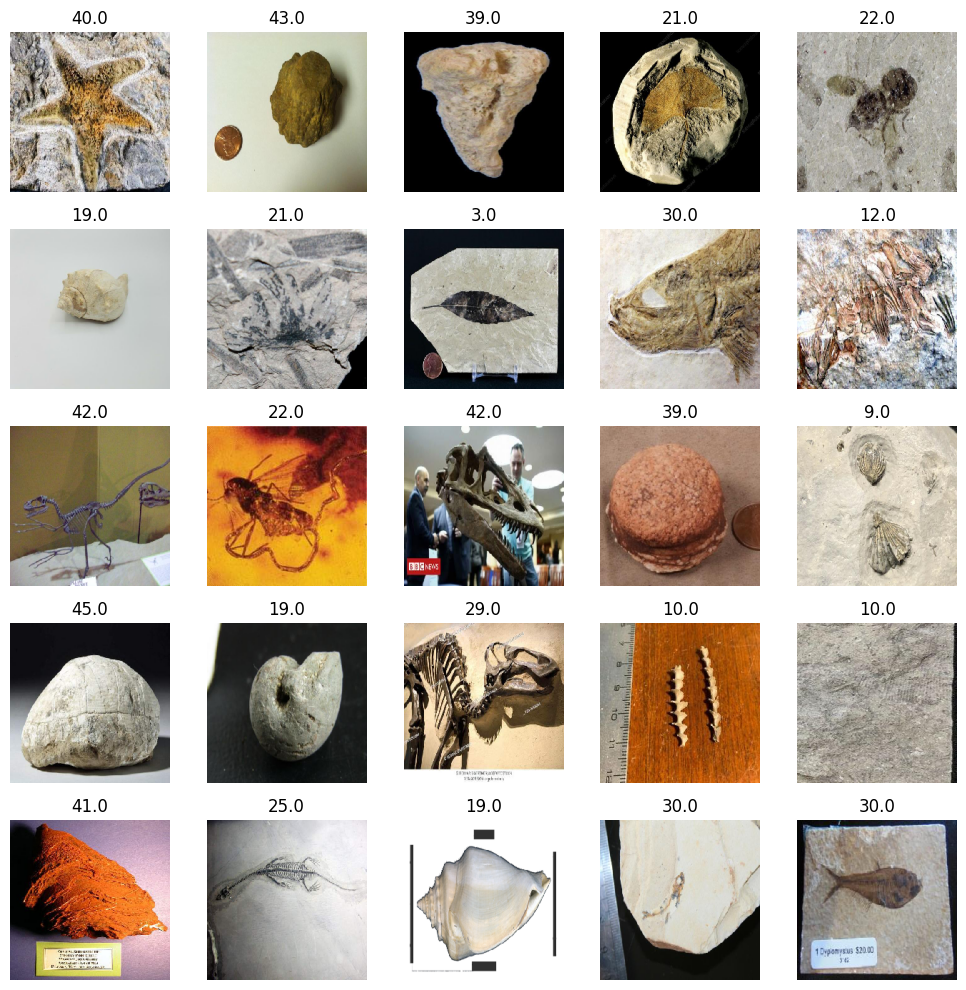

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 

# Plotting the first 25 images from the batch

img_train, label_train = next(train_set)

fig, axs =  plt.subplots(5,5, figsize=(10,10))

for i, ax in zip(range(25), axs.ravel()):
    ax.imshow(img_train[i])
    ax.axis('off')
    ax.set_title(label_train[i])
plt.tight_layout()
plt.show()

### Visualize the number of images in the train, valid and test sets.

Mean proportion of images in train set: 1124
Mean proportion of images in validation set: 307
Mean proportion of images in test set: 307


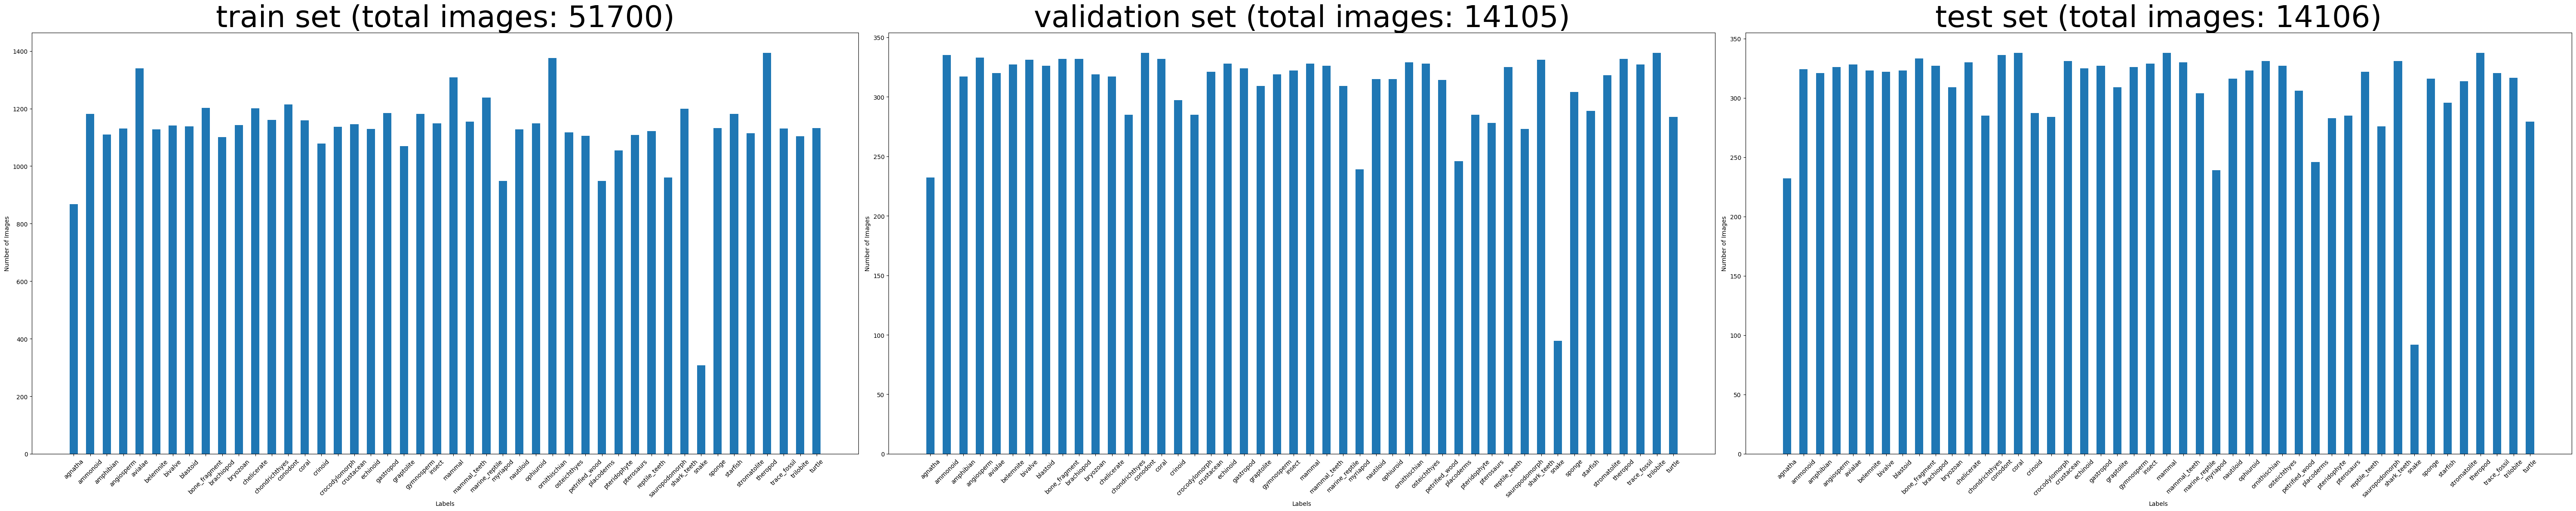

In [8]:
# Setup set names
set_names = ["train set", "validation set", "test set"]
categories = train_set.class_indices.keys()

# Plot
fig, axes = plt.subplots(1, 3, figsize=(60, 12))

for set_name, name, ax in zip(set_names, [train_set, valid_set, test_set], axes.ravel()):

    # Get the count of each label in the train set
    proportion = pd.value_counts(name.classes, normalize=False, sort=False)
    print("Mean proportion of images in {}: {:.0f}".format(set_name, proportion.mean()))
    
    ax.bar(categories, proportion, width=0.5)
    ax.set_title(f"{set_name} (total images: {len(name.classes)})", fontsize=50)
    ax.set(
        xlabel="Labels",
        ylabel="Number of Images",
    )
    ax.tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

We see a slight unbalance between the validation and test sets, but it's so small it will not impact the classifier. On average, each category as a reasonable number of images to perform decent deep learning.

### Baseline model

The goal is to create a baseline model that doesn't require much modeling. I will use the ``DummyClassifier`` to make predictions that ignore the input features. This is why I'm just flattening the images.

Due to memory constraints, I cannot flatten all the images in my dataset. To address this issue,  I will randomly select 10% of the images from each category.

This approach will provide me with a rough idea of how a model should perform, at the very least.

### Take a simple in each category and save the path

In [9]:
import random 

# Makes the random numbers predictable
random.seed(0)

# Initialize variables
percentage_to_extract = 10
samples = {}

# Extract directory names from the main folder
directorys = os.listdir(dir_path)

for direct in directorys:
    samples[direct] = {}
    
    folder_path = os.path.join(dir_path, direct)
    
    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        files_names = os.listdir(category_path)
        
        # Calculate the number of samples to extract. I take the minimum of 
        # the actual file count and the desired count to avoid sampling errors.
        num_samples_to_extract = min(len(files_names), int(np.ceil(len(files_names) * (percentage_to_extract / 100))))
        
        # Get full paths for the sampled images
        images_sample_path = [os.path.join(category_path, filename) for filename in random.sample(files_names, num_samples_to_extract)]
        
        # Store the paths of sampled images categorized by directory and category
        samples[direct][category] = images_sample_path

### Visualize the number of images sampled

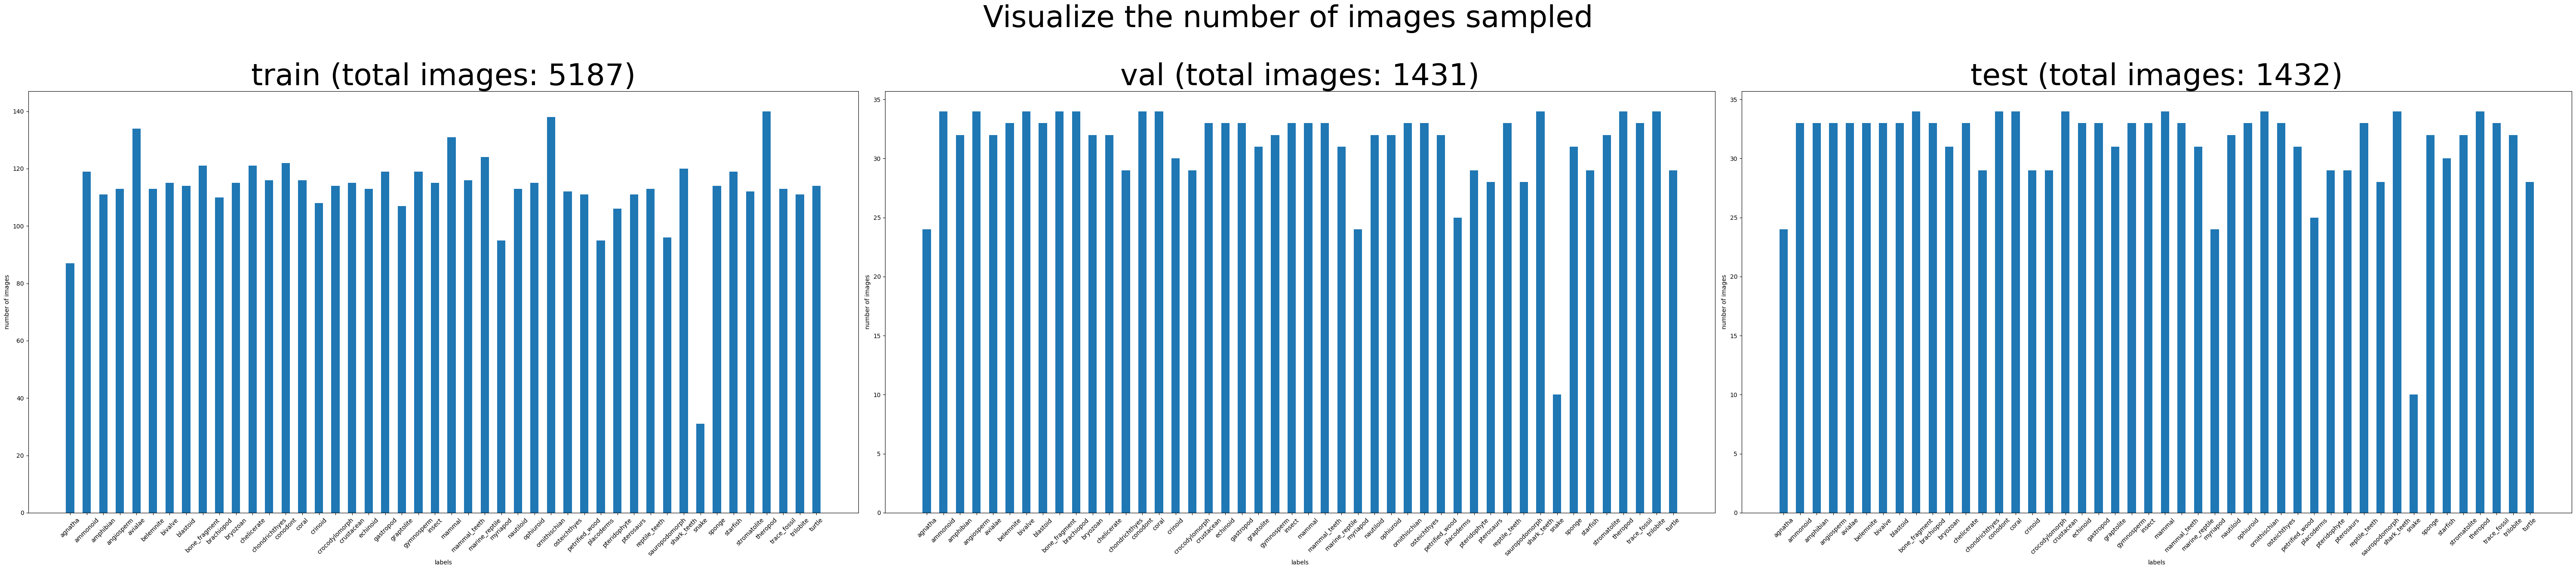

In [10]:
# Plot
fig, axes = plt.subplots(1, 3, figsize=(60, 12))

for idx, name in enumerate(["train", "val", "test"]):
    ax = axes[idx]  # Get the specific axis to plot on
    categories_names = samples[name].keys()
    data_amount = {}
    
    for category_name in categories_names:
        number_of_sample = len(samples[name][category_name])
        data_amount[category_name] = number_of_sample

    ax.bar(data_amount.keys(), data_amount.values(), width=0.5)
    ax.set_title(f"{name} (total images: {sum(data_amount.values())})", fontsize=50)
    ax.set(
        xlabel="labels",
        ylabel="number of images",
    )
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle("Visualize the number of images sampled", fontsize=50, y=1.1) 
plt.show()


All looks good. 

### Load the images

In [11]:
# Import required modules for image handling and transformations
from skimage import io
from skimage.transform import resize


# Initialize lists to store training, validation, and test image samples
X_train_sample, y_train_sample = [], []
X_valid_sample, y_valid_sample = [], []
X_test_sample, y_test_sample = [], []

# Loop through each dataset set (train, validation, and test)
for set_name in ["train", "val", "test"]:
    
    # Loop through each category within a given set
    for idx, category_name in enumerate(samples[set_name]):
        
        # Loop through all images within a category
        for img_path in samples[set_name][category_name]:
            
            # Read the image from the given path
            image = io.imread(img_path)
            
            # Resize the image to (224x224x3)
            resized_image = resize(image, (224, 224, 3))
            
            # Flatten the resized image
            flatten_img = resized_image.flatten()
            
            # Based on the set name, append the image data and corresponding category index to appropriate lists
            if set_name == "train":
                X_train_sample.append(flatten_img)
                y_train_sample.append(idx)
            elif set_name == "valid":
                X_valid_sample.append(flatten_img)
                y_valid_sample.append(idx)
            else:
                X_test_sample.append(flatten_img)
                y_test_sample.append(idx)

# Convert the lists to numpy arrays
X_train_sample, y_train_sample = np.array(X_train_sample), np.array(y_train_sample)
X_valid_sample, y_valid_sample = np.array(X_valid_sample), np.array(y_valid_sample)
X_test_sample, y_test_sample = np.array(X_test_sample), np.array(y_test_sample)


### Train the DummyClassifier

I will use ``strategy='most_frequent'``, as it predicts the most frequent class label.

In [12]:
from sklearn.dummy import DummyClassifier

# Initialise DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=0)

# fit 
dummy_clf.fit(X_train_sample, y_train_sample)


# Compute score of the best model on the test set
accruacy = dummy_clf.score(X_test_sample, y_test_sample)
print("Accuracy: {:.3%}".format(accruacy))

Accuracy: 2.375%


With a uniform distribution in our balanced dataset of 46 classes, each class has a probability of $\frac{1}{46}$ (or roughly 2.174%). A classifier predicting the most frequent class would achieve this accuracy, essentially matching random guessing

I will still use the model as my baseline. My next step will be to experiment with a simple classifier method that doesn't rely on sophisticated models.

# Simple classifier

The goal here is to see if standard machine learning can classify fossils. First I need a way to lower the complicity of my images by extracting important features.

To extract the features of an image. I will use Histogram of Oriented Gradients (HOG) as a feature descriptor algorithm. It converts raw pixels into a smaller, more informative features that can be used for machine learning. 

This algorithm enables me to describe the shape and the appearance of objects in an image. In short it divides the image into small cells, compute the histogram of the direction of the greatest intensity change for the pixels. Combining them to produce features vectors that provide a representation of the object shape within an image.

Here are the steps to extract HOG features: 
1. Load the image in this case I'm using ``io.imread()`` function from scikit-image. 
2.  To reduce complexity and prevent memory allocation issues, I will resize the image to 224x224.
3. Convert to grayscale this is done to lower the complicity of extracting features from the images using only one channel.
4. Normalize over a range [0, 1] and change the type to float to have better performance when working with hog extractors.
5. Extract hog features using hog function from scikit-image. The parameters are set to minimize computing time and size to avoid memory overload <a href="https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog">docs</a>. This will result in less accurate results it's a trade-off between accuracy and performance. Deep learning with CNN should perform faster and more accurately, but the goal here is to find a way to classify images using standard machine learning.


Source: 
<a href="https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html">Histogram of Oriented Gradients</a>

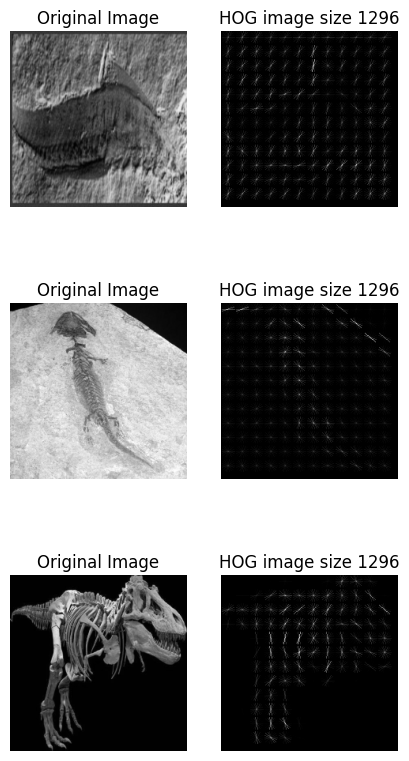

In [13]:
# Importing the required libraries
from skimage import color, img_as_float
from skimage.transform import resize
from skimage.feature import hog
import numpy as np

simple_of_image = ["data/illustrate-image/agnatha_905.jpg", "data/illustrate-image/amphibian_1.jpg", "data/illustrate-image/theropod_25.jpg"]

# Displaying the original image plus the images with horizontal and vertical edges
fig, ax = plt.subplots(nrows=len(simple_of_image), ncols=2, figsize=(5, 10))

for i, img_path in enumerate(simple_of_image):
    # Load an image
    image = io.imread(img_path)

    # Convert to gray-scale
    gray_image = color.rgb2gray(image)

    # Resize
    gray_image = resize(gray_image, (224, 224))

    # Normalize pixel values
    normalized_image = img_as_float(gray_image)

    # Extract HOG features
    hog_features, hog_image = hog(normalized_image, orientations=9, pixels_per_cell=(18, 18),
                        cells_per_block=(1, 1), visualize=True, transform_sqrt=True, channel_axis=None)
 
    # Displaying the original image
    ax[i, 0].imshow(gray_image, cmap="gray")
    ax[i, 0].set_title("Original Image")
    ax[i, 0].axis("off")

    # Displaying the HOG image
    ax[i, 1].imshow(hog_image, cmap="gray")
    ax[i, 1].set_title(f"HOG image size {hog_features.size}")
    ax[i, 1].axis("off")

plt.show()

We see that the HOG repesantion can be use to represent the objet shape in the images

### Next, extracting HOG features for all images

In [14]:
# Initialize a list to store the flattened image arrays
train_hog_features = []
valid_hog_features = []
test_hog_features = []

directory = ["train", "val", "test"]

for folder in directory:
    folder_path = os.path.join(dir_path, folder)

    # Loop over all subfolders in the directory
    for subfolder_name in os.listdir(folder_path):

        # Get the full path to the subfolder
        subfolder_path = os.path.join(folder_path, subfolder_name)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            for img_name in os.listdir(subfolder_path):
                # Save the full path for each image
                img_path = os.path.join(subfolder_path, img_name)

                # Load an image
                image = io.imread(img_path)

                # Convert to gray-scale
                gray_image = color.rgb2gray(image)

                # Resize
                gray_image = resize(gray_image, (224, 224))

                # Normalize pixel values
                normalized_image = img_as_float(gray_image)

               # Extract HOG features
                hog_features = hog(normalized_image, orientations=9, pixels_per_cell=(18, 18),
                        cells_per_block=(1, 1), visualize=False, transform_sqrt=True, channel_axis=None)
    
                if folder == directory[0]:
                    train_hog_features.append(hog_features)
                elif folder == directory[1]:
                    valid_hog_features.append(hog_features)
                else:
                    test_hog_features.append(hog_features)
    print(f"{folder} is done")


# Crate a numpy array to store the pixels
train_hog_features = np.array(train_hog_features)
valid_hog_features = np.array(valid_hog_features)
test_hog_features = np.array(test_hog_features)

# Merge train and valid 
X_merged = np.concatenate((train_hog_features, valid_hog_features), axis=0)
y_merged = np.concatenate((train_set.classes, valid_set.classes), axis=0)

train is done
val is done
test is done


### Classify images using HOG features
HOG features provide a simplified yet informative representation of the image. Now the objective is to classify them.

Steps to classify HOG features:

1. Set up a Pipeline to first standardize the HOG features to prepare them for the training process and medicated possible bade performance.
2. Using PCA to reduce the dimensionality of the HOG features to maximize the explained variance. which can subsequently speed up machine learning processes and reduce the risk of overfitting.
3. Classify the HOG features using ``SGDClassifier``. It's a linear classifier optimized by a stochastic gradient descent and can handle a large amount of data making it a good candidate for working with HOG features.
    - I'm seting loss to ``log_loss``  it gave the best result when testing mutiple loss function.
    - I'm stopping the traing when the validation score is not impoving using the ``early_stopping`` parameter.
4. I set up a grid search with cross-validation to fine-tune parameters.


Sources:

<a href="https://kapernikov.com/tutorial-image-classification-with-scikit-learn/">Tutorial: image classification with scikit-learn</a>

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html">SGDClassifier docs</a>

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

# Create pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.99, random_state=0)), # To reduce dimensionality while retaining 99% of the variance
    ("clf", SGDClassifier(loss="log_loss",  penalty="l2", learning_rate="adaptive", max_iter=1000, early_stopping=True, eta0=1e-3, random_state=0))
])

# Create grid parameters
param_grid = {
        #"scaler": [StandardScaler(), None], # scaling improve the accuracy
        #"clf__loss": ["hinge", "modified_huber", "squared_hinge", "perceptron", "log_loss"], # "log_loss" is the best-loss
        "clf__penalty": ["l2", "elasticnet"],
        "clf__alpha": [0.001, 0.01, 0.1], 
        #"clf__learning_rate": ["optimal", "invscaling", "adaptive"], # "adaptive" is the best learning_rate
        #"clf__eta0": [1e-3, 1e-4],  # default=1e-3 is the best
    }

# Create GridSearchCV
grid = GridSearchCV(pipe,
                    param_grid=param_grid,
                    cv=3,
                    return_train_score=True,
                    n_jobs=2, # to change depend on your configuration
                    verbose=1) 

# Train GridSearchCV
grid.fit(X_merged, y_merged)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=0.99, random_state=0)),
                                       ('clf',
                                        SGDClassifier(early_stopping=True,
                                                      eta0=0.001,
                                                      learning_rate='adaptive',
                                                      loss='log_loss',
                                                      random_state=0))]),
             n_jobs=2,
             param_grid={'clf__alpha': [0.001, 0.01, 0.1],
                         'clf__penalty': ['l2', 'elasticnet']},
             return_train_score=True, verbose=1)

In [16]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid.cv_results_)

# Select the columns we are interested in
col_of_interest = ["param_clf__alpha", "param_clf__penalty",  "mean_test_score",
                   "mean_train_score", "std_test_score", "std_train_score"]
cv_results = cv_results[col_of_interest]

# Show the dataframe sorted according to our performance metric
cv_results.sort_values("mean_test_score", ascending=False).head()

param_clf__alpha param_clf__penalty  mean_test_score  mean_train_score  \
2             0.01                 l2         0.141251          0.267457   
1            0.001         elasticnet         0.138394          0.280921   
0            0.001                 l2         0.136920          0.302507   
4              0.1                 l2         0.127437          0.174782   
3             0.01         elasticnet         0.117955          0.136950   

   std_test_score  std_train_score  
2        0.013647         0.013246  
1        0.014015         0.016310  
0        0.016024         0.016923  
4        0.006950         0.006115  
3        0.004741         0.003106

### Plot train and test curves

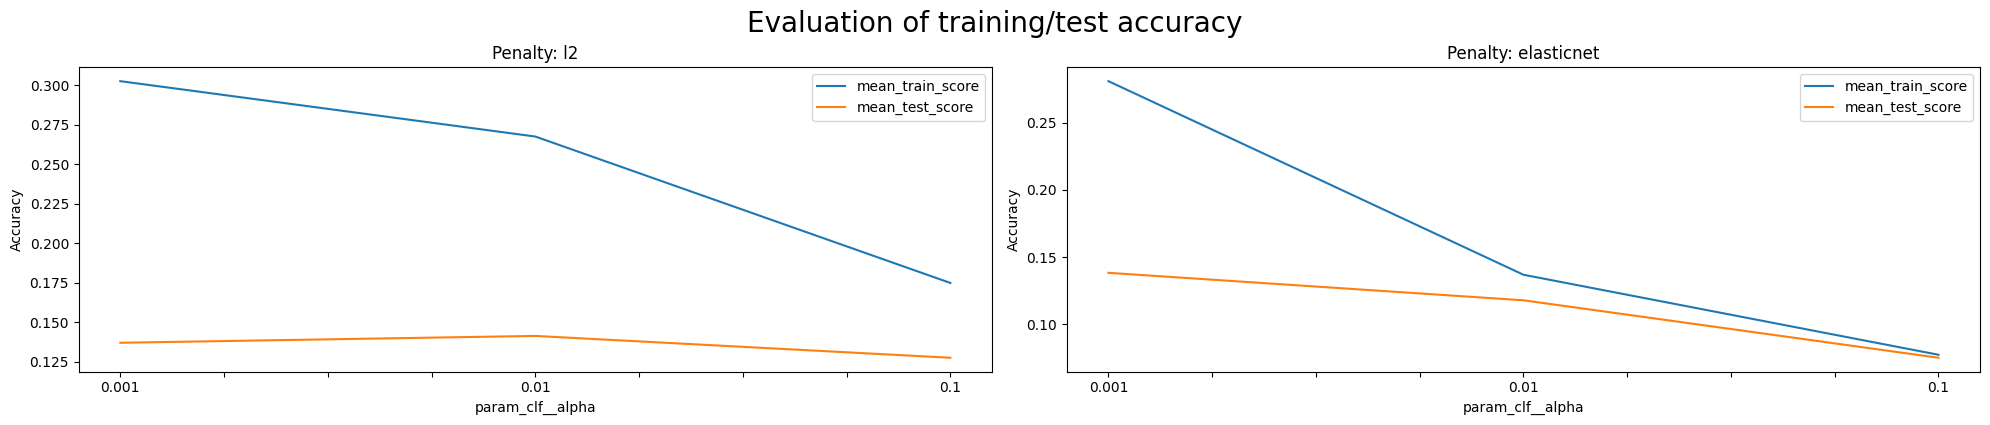

In [17]:
# List of penalty types to plot
combinations = ["l2", "elasticnet"]

# Creates a figure with two subplots (one for each penalty type)
fig, ax = plt.subplots(1, 2, figsize=(20, 4))

# Loop through each penalty type
for i, combination in enumerate(combinations):

    # Filter the results to only include rows with the current penalty type
    mask = cv_results["param_clf__penalty"].astype("str") == str(combination)

    # Set the 'param_clf__alpha' as the index
    df_cv = cv_results[mask].set_index("param_clf__alpha")

    # Plot mean train and test scores for the current penalty type
    df_cv[["mean_train_score", "mean_test_score"]].plot(ax=ax[i], legend=True)

    # Set the title and y-label of the current subplot
    ax[i].set_title(f"Penalty: {combination}")
    ax[i].set_ylabel("Accuracy")

# Adjust the layout to ensure the plots and titles don't overlap
plt.tight_layout()
plt.suptitle("Evaluation of training/test accuracy", y=1.05, fontsize=20)
plt.show()

We see a wide gap between the training and test (actually validation) scores. Overall, the model performs poorly, and the HOG features extracted don't provide enough information. let's compute the accuracy of the test set.

In [18]:
# Compute score on the test set
simple_model =  grid.best_estimator_
acc_of_simple_model = simple_model .score(test_hog_features, test_set.classes)
print("Accuracy: {:.2%}".format(acc_of_simple_model))

Accuracy: 17.62%


The accuracy is quite low, nevertheless, it is much better than my baseline model. Next, I will try to extract high-level features using deep learning and see what accuracy I can achieve.

### Extract high-level features and set up a classifier

I opted for __MobileNetV3Large__. It's an updated version of MobileNetV2 and incorporates the h-swish activation function. This is expected to yield better accuracy and efficiency compared to MobileNetV2, which uses ReLU6.

- Fit and tune a k-NN classifier with PCA.
    - k-NN classifier is a simple, effective and fast algorithm for classification tasks. 
    - PCA will help me condense the information while retaining the most of the important information.

Due to the size of my database, I will not use ``tensorflow_hub``.  Instead, I will load ``MobileNetV3Large`` pretrained model makes the base model non-trainable and add a ``GlobalAveragePooling2D()`` it computes the average value of all pixels in the output of a convolutional layer representing specific features (feature map), resulting in a single vector per image.

In [19]:
import tensorflow as tf

# Clear the session
tf.keras.backend.clear_session()

In [20]:
from tensorflow.keras.applications import MobileNetV3Large

# Load pretrained model
base_model = MobileNetV3Large(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_preprocessing=False, # Don't inculde the preprocessing layers 
    include_top=False, # Don't include the ImageNet classifier at the top.
    pooling="avg", # This means that global average pooling will be applied to the output of the last convolutional layer, 
                   # and thus the output of the model will be a 2D tensor.
)

# Make the base model non-trainable
base_model.trainable = False

# Extract features 
X_train = base_model.predict(train_set)
X_valid = base_model.predict(valid_set)
X_test = base_model.predict(test_set)

# Merge features and label train/validation set
X = np.concatenate((X_train, X_valid), axis=0)
y = np.concatenate((train_set.classes, valid_set.classes), axis=0)

221/221 [==============================] - 41s 184ms/step


### Fit and tune a k-NN classifier

In [21]:
from sklearn.neighbors import KNeighborsClassifier

### Fit and tune a k-NN classifier

pipe_knn = Pipeline([
    ("pca", PCA(n_components=0.99, random_state=0)), # PCA to reduce the dimensionality of data while preserving as much variance as possible.
    ("knn", KNeighborsClassifier())
])

param_grid_knn = {
                "knn__n_neighbors": [100, 200],
                "knn__weights": ["uniform", "distance"],
}

grid_knn = GridSearchCV(pipe_knn,
                    param_grid=param_grid_knn,
                    cv=3,
                    return_train_score=True,
                    n_jobs=2, # to change depend on your configuration
                    verbose=1)

grid_knn.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=0.99, random_state=0)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=2,
             param_grid={'knn__n_neighbors': [100, 200],
                         'knn__weights': ['uniform', 'distance']},
             return_train_score=True, verbose=1)

In [22]:
# Collect results in a DataFrame
cv_results_knn = pd.DataFrame(grid_knn.cv_results_)

# Select the columns we are interested in
col_of_interest = ["param_knn__n_neighbors", "param_knn__weights", "mean_test_score",
                   "mean_train_score", "std_test_score", "std_train_score"]
cv_results_knn = cv_results_knn[col_of_interest]

# Show the dataframe sorted according to our performance metric
cv_results_knn.sort_values("mean_test_score", ascending=False).head()

param_knn__n_neighbors param_knn__weights  mean_test_score  \
1                    100           distance         0.022795   
3                    200           distance         0.022506   
0                    100            uniform         0.022506   
2                    200            uniform         0.022460   

   mean_train_score  std_test_score  std_train_score  
1          0.935955        0.000966         0.044675  
3          0.935955        0.000712         0.044675  
0          0.141463        0.000352         0.055940  
2          0.129291        0.000354         0.056753

### Visualizing the accuracy curves

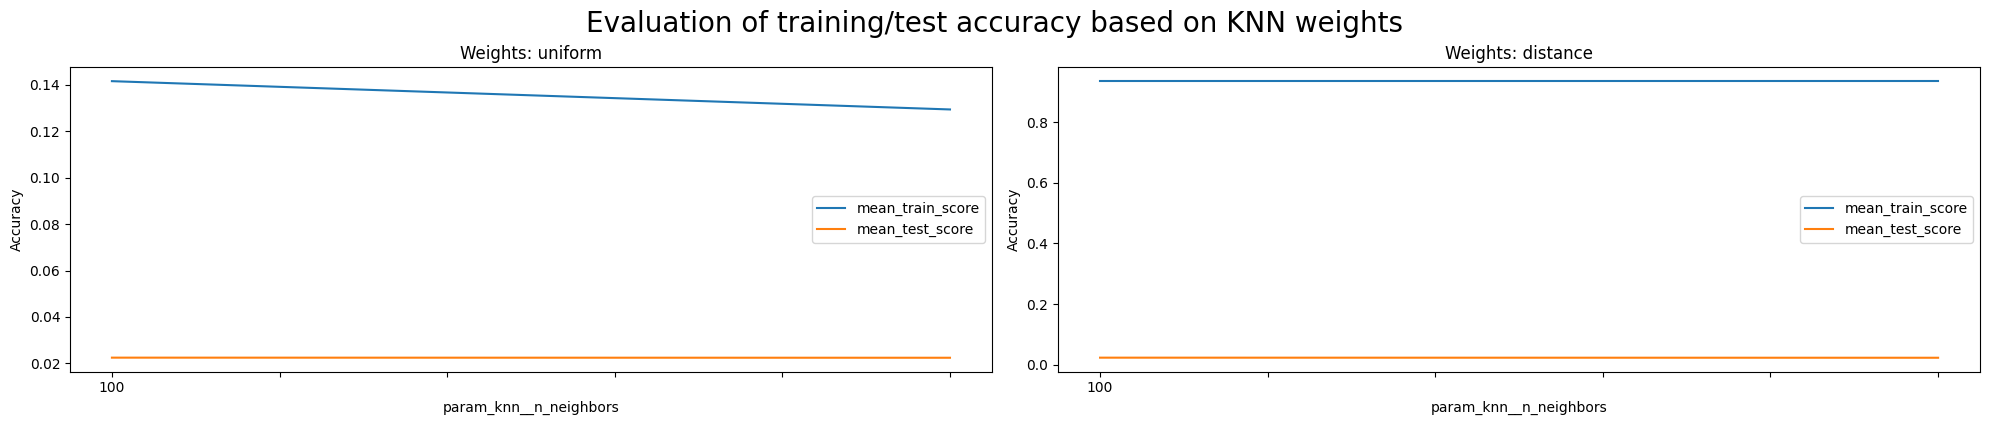

In [23]:
# List of weight options to plot
weight_options = ["uniform", "distance"]

# Creates a figure with two subplots (one for each weight option)
fig, ax = plt.subplots(1, 2, figsize=(20, 4))

# Loop through each weight option
for i, weight_option in enumerate(weight_options):

    # Filter the results to only include rows with the current weight option
    mask = cv_results_knn["param_knn__weights"].astype("str") == str(weight_option)

    # Set the 'param_knn__n_neighbors' as the index
    df_cv = cv_results_knn[mask].set_index("param_knn__n_neighbors")

    # Plot mean train and test scores for the current weight option
    df_cv[["mean_train_score", "mean_test_score"]].plot(ax=ax[i], legend=True)

    # Set the title and y-label of the current subplot
    ax[i].set_title(f"Weights: {weight_option}")
    ax[i].set_ylabel("Accuracy")

# Adjust the layout to ensure the plots and titles don't overlap
plt.tight_layout()
plt.suptitle("Evaluation of training/test accuracy based on KNN weights", y=1.05, fontsize=20)
plt.show()

In general, we overfit the validation set and we stagnate. Let's compute the score of the ``test_set`` and see what accuracy we can achieve.

In [24]:
# Compute score of the best model on the test set
knn_model = grid_knn.best_estimator_
knn_result = knn_model.score(X_test, test_set.classes)
print("Accuracy: {:.3%}".format(knn_result))

Accuracy: 28.484%


We get a much better result when working with high-level features. 

### Can I do better using another algorithm?

I will try with logistic regression, to speedup the train. I will use ``SGDClassifier`` whish use uses stochastic gradient descent (SGD), instead of computing the gradient using the entire dataset, SGD updates the weights using only a single or a few samples for each iteration. This can lead to much faster convergence, especially for large datasets.


In [25]:
# Create pipeline
pipe_lr = Pipeline([
    ("pca", PCA(n_components=0.99, random_state=0)), # PCA to reduce the dimensionality of data while preserving as much variance as possible.
    ("clf", SGDClassifier(loss="log_loss", learning_rate="adaptive", max_iter=1000, eta0=1e-3, early_stopping=True, random_state=0))
])

# Create grid parameters
param_grid_lr = {
        "clf__penalty": ["l2", "elasticnet"],
        "clf__alpha": [0.00001, 0.0001], 
        #"clf__learning_rate": ["optimal", "invscaling", "adaptive"], # "adaptive" is the best learning_rate
        #"clf__eta0": [1e-3, 1e-4],  # 1e-3 is the best
    }

# Create GridSearchCV
grid_lr = GridSearchCV(pipe_lr,
                    param_grid=param_grid_lr,
                    cv=3,
                    return_train_score=True,
                    n_jobs=2, # to change depend on your configuration
                    verbose=1) 

# Train GridSearchCV
grid_lr.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=0.99, random_state=0)),
                                       ('clf',
                                        SGDClassifier(early_stopping=True,
                                                      eta0=0.001,
                                                      learning_rate='adaptive',
                                                      loss='log_loss',
                                                      random_state=0))]),
             n_jobs=2,
             param_grid={'clf__alpha': [1e-05, 0.0001],
                         'clf__penalty': ['l2', 'elasticnet']},
             return_train_score=True, verbose=1)

In [26]:
# Collect results in a DataFrame
cv_results_lr = pd.DataFrame(grid_lr.cv_results_)

# Select the columns we are interested in
col_of_interest = ["param_clf__penalty",  "param_clf__alpha", "mean_test_score",
                   "mean_train_score", "std_test_score", "std_train_score"]
cv_results_lr = cv_results_lr[col_of_interest]

# Show the dataframe sorted according to our performance metric
cv_results_lr.sort_values("mean_test_score", ascending=False).head()

param_clf__penalty param_clf__alpha  mean_test_score  mean_train_score  \
3         elasticnet           0.0001         0.022050          0.184811   
2                 l2           0.0001         0.021974          0.185183   
1         elasticnet          0.00001         0.021913          0.185206   
0                 l2          0.00001         0.021868          0.185252   

   std_test_score  std_train_score  
3        0.000633         0.059214  
2        0.000591         0.058961  
1        0.000633         0.058993  
0        0.000614         0.059009

### Visualizing the accuracy curves

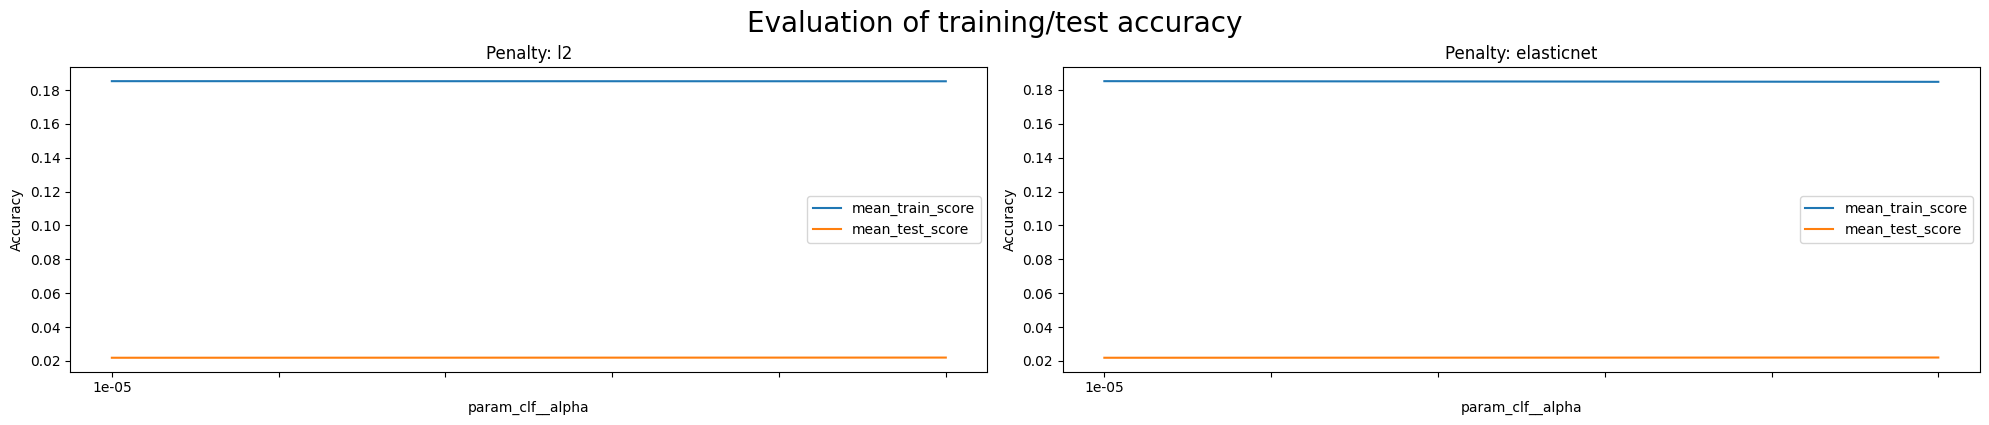

In [27]:
# List of penalty types to plot
combinations = ["l2", "elasticnet"]

# Creates a figure with two subplots (one for each penalty type)
fig, ax = plt.subplots(1, 2, figsize=(20, 4))

# Loop through each penalty type
for i, combination in enumerate(combinations):

    # Filter the results to only include rows with the current penalty type
    mask = cv_results_lr["param_clf__penalty"].astype("str") == str(combination)

    # Set the 'param_clf__alpha' as the index
    df_cv = cv_results_lr[mask].set_index("param_clf__alpha")

    # Plot mean train and test scores for the current penalty type
    df_cv[["mean_train_score", "mean_test_score"]].plot(ax=ax[i], legend=True)

    # Set the title and y-label of the current subplot
    ax[i].set_title(f"Penalty: {combination}")
    ax[i].set_ylabel("Accuracy")

# Adjust the layout to ensure the plots and titles don't overlap
plt.tight_layout()
plt.suptitle("Evaluation of training/test accuracy", y=1.05, fontsize=20)
plt.show()

We see a wide gap between the training and validation scores. Overall, the model performs poorly. Let's compute the score of the ``test_set`` and see what accuracy we can achieve.

### Compute score on the test set

In [28]:
# Compute score on the test set
lr_model =  grid_lr.best_estimator_
lr_acc = lr_model.score(X_test, test_set.classes)
print("Accuracy: {:.2%}".format(lr_acc))

Accuracy: 44.09%


The accuracy is okay. Let's try with a more complex model.

### Deep learning

Despite trying multiple machine learning models such as ``KNeighborsClassifier``, ``SGDClassifier``. I still can't achieve good enough results. The possible cause of poor performance could be due to the method of feature extraction. Currently, I am using a pretrained model __MobileNetV3Large__, which was trained on the ImageNet dataset. Since fossil images were not encountered during the model's pretraining, it might not be able to extract meaningful features.

To address this issue, I plan to fine-tune the pretrained model and train a custom classifier on top of it. By doing so, the model should adapt better to my fossil images, potentially resulting in improved accuracy.

To fine-tune my model, I will use the functional API from Keras. This enables me to freeze some layers and train the layers above that. The reason for this approach is that the earlier layers in the pretrained model capture more general features that could be beneficial. On the other hand, the later layers are more specialized to the original ImageNet task and might require adaptation to better suit my fossil images.

>**Note**: This task is computationally intense, and having access to a GPU is recommended. The code provided below might take a long time to run.

### Load the images

I'm performing data augmentation on the train set to artificially increase the size of my training set and introduce more variables, which can improve performance and help prevent overfitting.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

dir_path = os.path.join("data", "reduced-FID-cleaned-splited")


# Define data augmentation settings
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=False,
                                    fill_mode="constant",
                                    cval=0, #  This will fill the new pixels with black
                                )


train_set = train_datagen.flow_from_directory(
        os.path.join(dir_path, "train"),
        shuffle=True,
        target_size=(224, 224),
        batch_size=64,
        class_mode="sparse",
        )


Found 51700 images belonging to 46 classes.


### Visualize some image generated

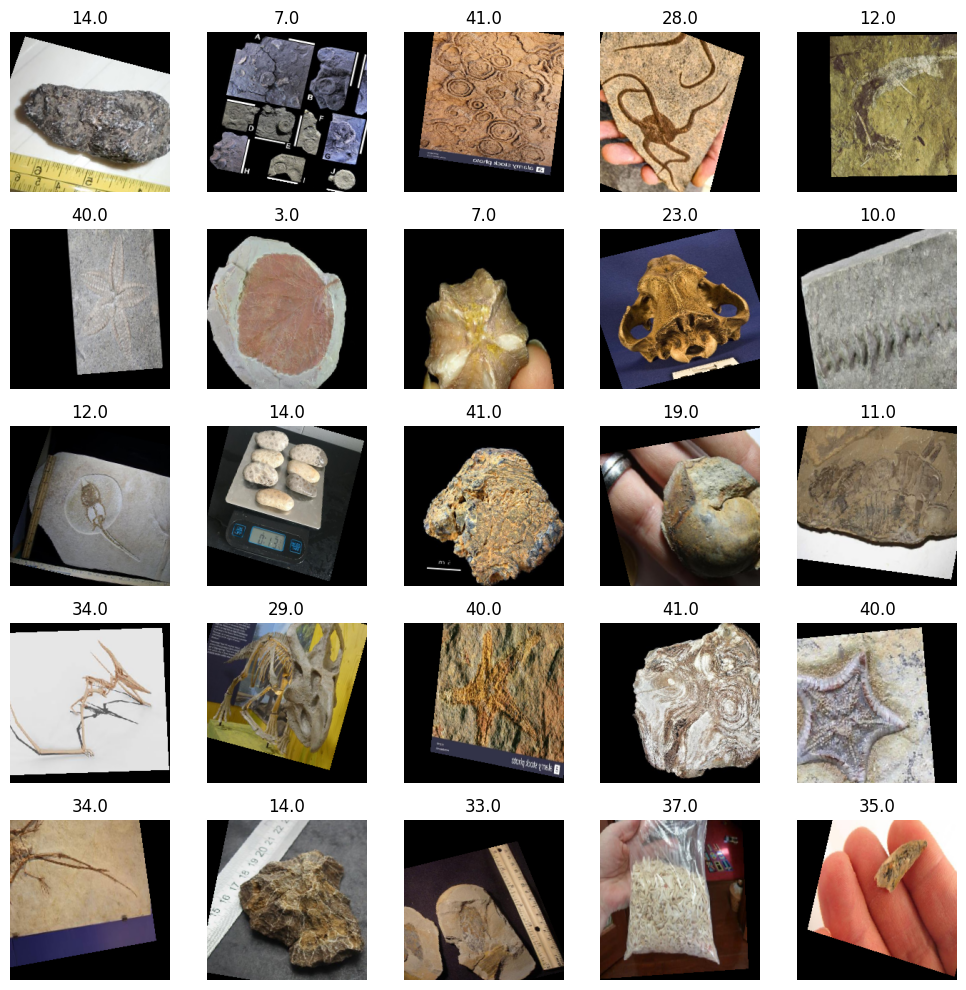

In [ ]:
# Extract a batch of images and labels from train_set
images, labels = next(train_set)


# Plotting the first 25 images from the batch

img_train, label_train = next(train_set)

fig, axs =  plt.subplots(5,5, figsize=(10,10))

for i, ax in zip(range(25), axs.ravel()):
    ax.imshow(img_train[i])
    ax.axis('off')
    ax.set_title(label_train[i])
plt.tight_layout()
plt.show()

### Let's define the model

In [ ]:
# Clear the session
tf.keras.backend.clear_session()

In [ ]:
import tensorflow.keras as keras

# Load the pretrained model
base_model =  MobileNetV3Large(input_shape=(224, 224, 3), weights="imagenet", include_top=False, include_preprocessing=False)

# Make layers of the base model trainable
base_model.trainable = True

# Get the number of layers for the base_model
print(f"The base_model has {len(base_model.layers)} layers.")

# Unfreeze the last few layers for fine-tuning
fine_tune_at = 255

# Freezes the weights of the pre-train model
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


# Creat a new classification layers on top
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
outputs = keras.layers.Dense(train_set.num_classes, activation="softmax")(x)

# Define the model
model = keras.Model(inputs=base_model.input, outputs=outputs)


# Compile the model
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["acc"])

# Print network summary
model.summary()

The base_model has 262 layers.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 112, 112, 16  64         ['Conv[0][0]']                   
 tion)                          )                              

### Train the model 

In [ ]:
# Code to load the save-model.h5 if needed

""" # Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model("save-model.h5")

# Show the model architecture
model.summary() """

' # Recreate the exact same model, including its weights and the optimizer\nmodel = tf.keras.models.load_model("save-model.h5")\n\n# Show the model architecture\nmodel.summary() '

>The code below can take a long time to run, approximately 2 hours.

In [ ]:
### Code to train the model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# End trainging whe accuracy stops improving
early_stopping = EarlyStopping(monitor="val_loss", patience=20)

# Reduce learning rate if val_loss doesn't improve
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1,
                              patience=3, min_lr=1e-10)

# Define model checkpoint
checkpoint = ModelCheckpoint("save-model.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

# Fit model
history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=200,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1,
    workers=4, # Number of workers Depend on your configuration
)

Epoch 1/200
808/808 [==============================] - ETA: 0s - loss: 2.0627 - acc: 0.4271
Epoch 1: val_loss improved from inf to 1.63338, saving model to save-model.h5
808/808 [==============================] - 127s 152ms/step - loss: 2.0627 - acc: 0.4271 - val_loss: 1.6334 - val_acc: 0.5392 - lr: 0.0010
Epoch 2/200
808/808 [==============================] - ETA: 0s - loss: 1.6157 - acc: 0.5464
Epoch 2: val_loss improved from 1.63338 to 1.44823, saving model to save-model.h5
808/808 [==============================] - 121s 150ms/step - loss: 1.6157 - acc: 0.5464 - val_loss: 1.4482 - val_acc: 0.5921 - lr: 0.0010
Epoch 3/200
808/808 [==============================] - ETA: 0s - loss: 1.4489 - acc: 0.5894
Epoch 3: val_loss improved from 1.44823 to 1.32481, saving model to save-model.h5
808/808 [==============================] - 123s 151ms/step - loss: 1.4489 - acc: 0.5894 - val_loss: 1.3248 - val_acc: 0.6321 - lr: 0.0010
Epoch 4/200
808/808 [==============================] - ETA: 0s - los

In [ ]:
# Save model
model.save("fossil-classifier.h5")

### Plot accuracy and loss metrics for both training and validation data

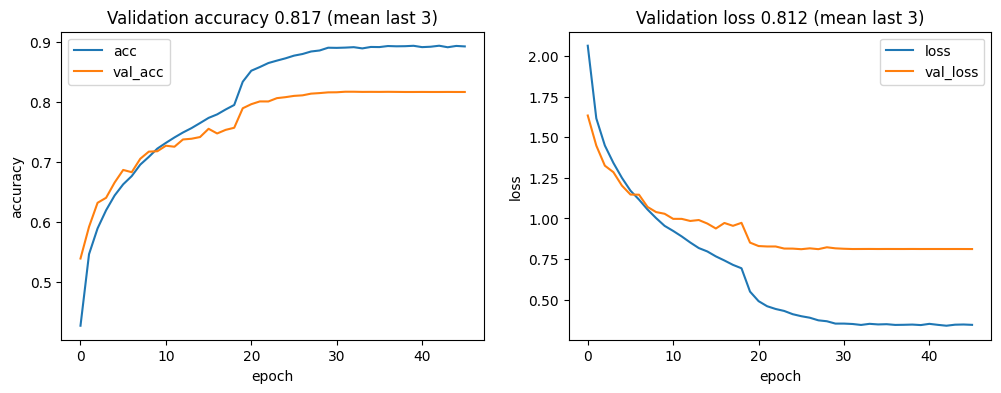

In [ ]:
# Plots neural network performance metrics for train and validation
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Get the performance metrics
results = pd.DataFrame(history.history)

# Plot accuracy curves
results[["acc", "val_acc"]].plot(ax=ax1)
ax1.set_title(
    "Validation accuracy {:.3f} (mean last 3)".format(
        np.mean(results["val_acc"][-3:]) # Last three values
    )
)
ax1.set_xlabel("epoch")
ax1.set_ylabel("accuracy")

# Plot loss curves
results[["loss", "val_loss"]].plot(ax=ax2)
ax2.set_title(
    "Validation loss {:.3f} (mean last 3)".format(
        np.mean(results["val_loss"][-3:]) # Last three values
    )
)
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")

plt.show()

Our model is not so bad. Let's go ahead and compute the accuracy score of the test set.

### Compute score on the test set

In [ ]:
# Compute score on the test set
(test_loss, test_accuracy) = model.evaluate(test_set)

print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2%}".format(test_accuracy))

221/221 [==============================] - 20s 92ms/step - loss: 0.8018 - acc: 0.8183
Test loss: 0.80
Test accuracy: 81.83%


The accuracy I've achieved is good.

__As a side note, I achieved an accuracy of 89% using a more complex model.__ 

Due to the complexity of classifying fossils, I tried using a more powerful model that should be able to extract meaningful features more precisely. I've chosen to use __InceptionV3__, as it generally offers better accuracy. However, this comes at the cost of being more computationally intensive.

Unfortunately, training this model on a standard machine won't be feasible, we need something more powerful.

>Here is to notebooks in Google Colab were the model was trained:<a href="https://drive.google.com/file/d/1IlZANaZbZnGmJSrYMkOEVCpojBWCsQ2o/view?usp=sharing"> Colab notebook</a>.

Here is the dataset I used to train the model: [reduced-FID-cleaned-splited.zip](https://drive.google.com/file/d/1HHanbv0tYjS_UyJue5FwbGuAIhMe_raw/view?usp=sharing)


# Conclusion

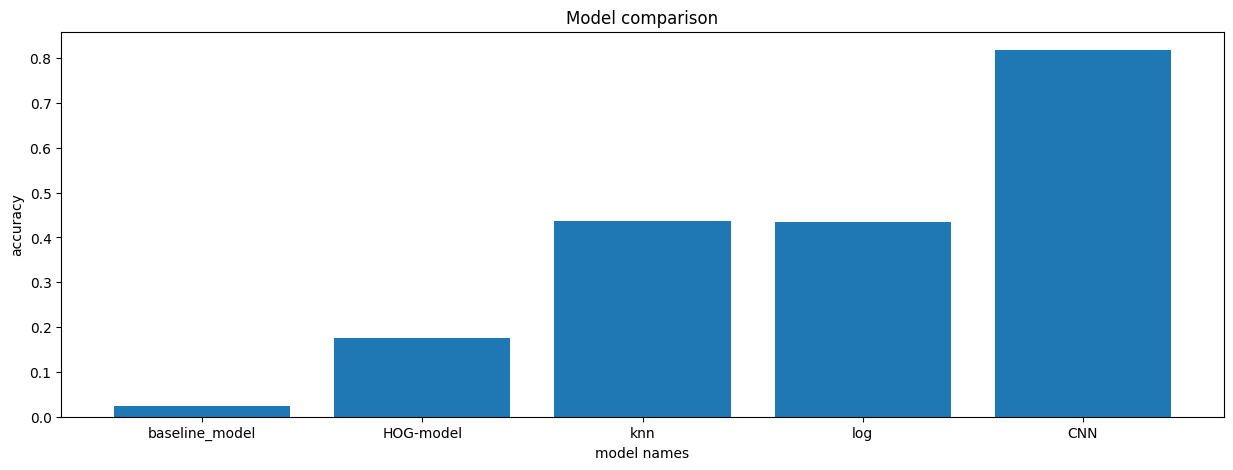

In [ ]:
# Plot the deferent model 
results = {
    "model": ["baseline_model", "HOG-model", "knn", "log", "CNN"],
    "test_accuracy" : [accruacy, acc_of_simple_model, knn_result, lr_acc, test_accuracy]
}


# Plot Model comparison
plt.figure(figsize=(15, 5))
plt.bar(results["model"], results["test_accuracy"])
plt.title("Model comparison")
plt.xlabel("model names")
plt.ylabel("accuracy")
plt.show()

In summary, our fossil classification efforts have yielded good results. Our best model achieves an 82% accuracy rate, and with the more complex model, we reached an even better 89% accuracy (not shown in the plot). However, it's important to note that accurately classifying fossils can be challenging, even for humans.